In [2]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using FUSE.IMAS

  Activating environment at `~/.julia/dev/FUSE/Project.toml`


In [144]:
dd=IMAS.json2imas("/Users/meneghini/.julia/dev/FUSE/sample/CAT_eq_ods.json");

In [193]:
using Plots
import Plots:plot

function Plots.plot!(pf_active::IMAS.pf_active)
    Plots.plot!([c.element[1].geometry.rectangle.r for c in pf_active.coil],[c.element[1].geometry.rectangle.z for c in pf_active.coil],markershape=:rect,lw=0,label="",aspect=:equal)
end

function Plots.plot!(pfactor::PFcoilsOptActor, plot_trace=false)
    # plot mask
    rmask=pfactor.rmask
    zmask=pfactor.zmask
    dst=pfactor.mask_log_interpolant(zmask,rmask)
    plt=plot([NaN],[NaN],xlim=[rmask[1],rmask[end]],ylim=[zmask[1],zmask[end]],aspect_ratio=:equal,label="")
    contour!(rmask,zmask,dst,levels=[0.5],xlim=[rmask[1],rmask[end]],ylim=[zmask[1],zmask[end]], aspect_ratio=:equal,colorbar=false)
    
    # plot pf_active coils
    Plots.plot!(pfactor.pf_active)
    plot!(pfactor.eq_in.time_slice[1];label="Initial",lcfs=true, color=:black)
    plot!(pfactor.eq_out.time_slice[1];label="Final",color=:red)

    if plot_trace
        if length(pfactor.trace.coils)>0
            for c in 1:length(pfactor.trace.coils[1])
                plot!([FUSE.no_Dual(k[c][1]) for k in pfactor.trace.coils],[FUSE.no_Dual(k[c][2]) for k in pfactor.trace.coils],label="", lw=1, alpha=0.5)
            end
        end
    end
    return plt
end

function Plots.plot!(eqt::IMAS.equilibrium__time_slice; lcfs=false, kw...)
    if lcfs
        psi_levels=[eqt.global_quantities.psi_boundary,eqt.global_quantities.psi_boundary]
        psi_levels_out=[]
    else
        psi_levels=range(eqt.global_quantities.psi_axis,eqt.global_quantities.psi_boundary,length=11)
        psi_levels_out=(psi_levels[end]-psi_levels[1]).*collect(range(0,1,length=11)).+psi_levels[end]
    end

    kw_lcfs=(;kw...,:lw=>2)

    k=1
    primary=true
    for psi_level in vcat(psi_levels[2:end],psi_levels_out)
        for (pr,pz) in IMAS.flux_surface(eqt, psi_level, false)
            primary = k==1 ? true : false
            if psi_level == eqt.global_quantities.psi_boundary
                Plots.plot!(pr, pz; primary=primary, kw_lcfs...)
            else
                Plots.plot!(pr, pz; primary=primary,kw...)
            end
            k+=1
        end
    end
    Plots.plot!([eqt.global_quantities.magnetic_axis.r], [eqt.global_quantities.magnetic_axis.z];marker=:cross, primary=primary,kw...)
end

function Plots.plot!(trace::FUSE.PFcoilsOptTrace, start_at::Int=1, what::Symbol=:cost; kw...)
    x=(start_at:length(trace.cost))
    if what == :cost
        plot(x,[FUSE.no_Dual(y) for y in trace.cost_ψ[start_at:end]],label="ψ"; kw...)
        plot!(x,[FUSE.no_Dual(y) for y in trace.cost_currents[start_at:end]],label="currents"; kw...)
        plot!(x,[FUSE.no_Dual(y) for y in trace.cost_bound[start_at:end]],label="bounds"; kw...)
        plot!(x,[FUSE.no_Dual(y) for y in trace.cost[start_at:end]],label="total",color=:black; kw...)
    elseif what == :currents
        #plot!([FUSE.no_Dual(y) for y in getfield(trace,what)[start_at:end]][1,:],label="Initial"; kw...)
        plot!([FUSE.no_Dual(y) for y in getfield(trace,what)[start_at:end]][end,:],label="Final"; kw...)
    else
        plot!(x,[FUSE.no_Dual(y) for y in getfield(trace,what)[start_at:end]],label=String(what); kw...)
    end
end


In [183]:
using Statistics
function add_thickness(r,z,thikness)

    mr=Statistics.mean(r[1:end])
    dr=maximum(r)-minimum(r)
    mz=Statistics.mean(z[1:end])
    dz=maximum(z)-minimum(z)
    
    xr=thikness/dr
    xz=thikness/dz

    return @. (r-mr)*(1+xr)+mr,(z-mz)*(1+xz)+mz
end

rCSout=[0.7,7.3,7.3,0.7,0.7]
zCSout=[4.8,4.8,-4.8,-4.8,4.8]
rCSblanket,zCSblanket=add_thickness(rCSout,rCSout,-0.8)
rBlanket,zBlanket=add_thickness(rCSblanket,zCSblanket,-1.0)
rCryo=[0.0,10,10,0.0,0.0]
zCryo=[6,6,-6,-6,6];

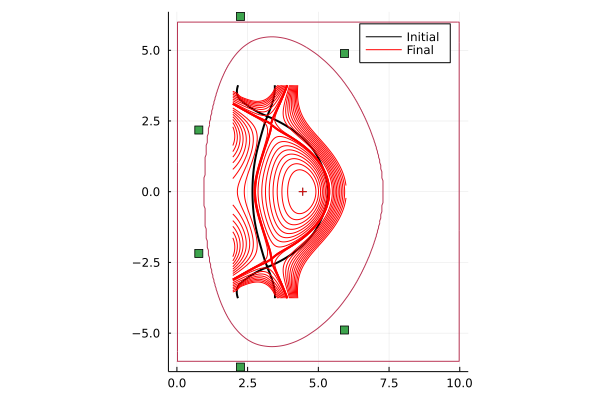

 * Status: success

 * Candidate solution
    Final objective value:     6.097004e-01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit 30)
    Iterations:    655
    f(x) calls:    1122



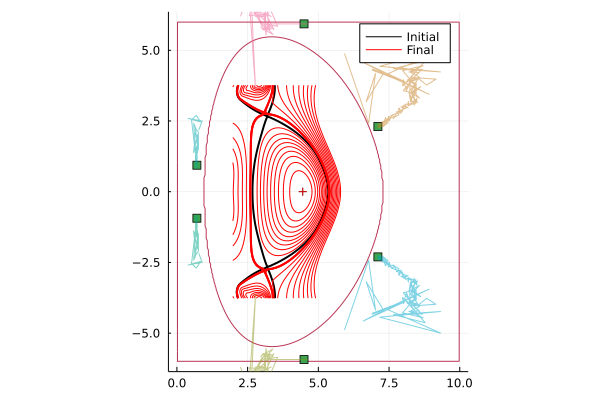

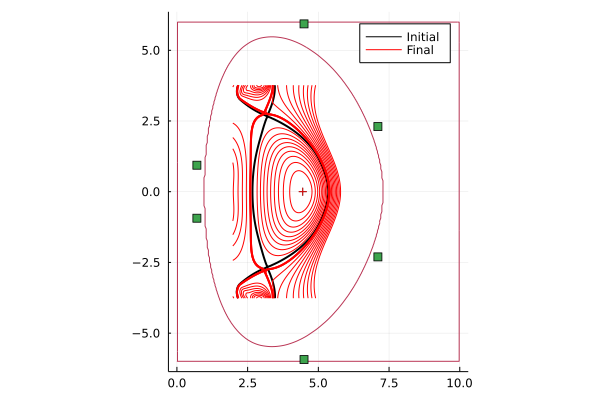

In [308]:
#pfoptactor=PFcoilsOptActor(dd.equilibrium,0.006, 6, 1E-13, zip(rCSout,zCSout), zip(rCryo,zCryo));
pfoptactor=PFcoilsOptActor(dd.equilibrium,0.006, 6, 1E-13, 4.5 ,zip(rCryo,zCryo));

display(plot!(pfoptactor))

step(pfoptactor,symmetric=true,λ_currents=1E7, verbose=true);

display(plot!(pfoptactor,true))
display(plot!(pfoptactor,false));

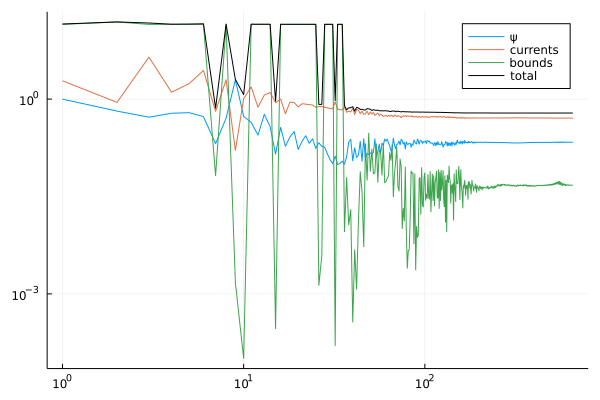

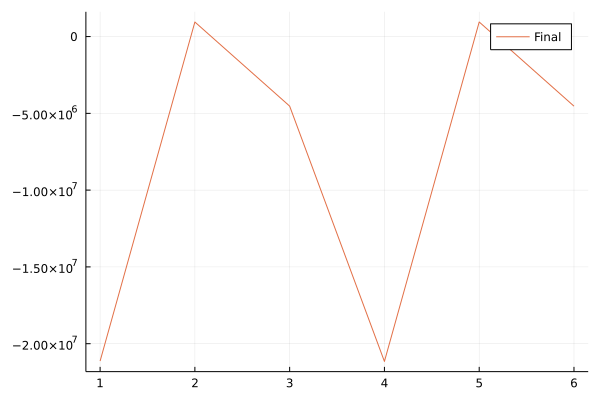

In [309]:
display(plot!(pfoptactor.trace,1,:cost,yscale=:log10,xscale=:log10))

plot([NaN],[NaN],label="")
display(plot!(pfoptactor.trace,1,:currents))

In [211]:
import LinearAlgebra
repeat([1,2,3],1,3)-repeat(transpose([1,2,3]),3,1)-LinearAlgebra.I

3×3 Matrix{Int64}:
 -1  -1  -2
  1  -1  -1
  2   1  -1

In [209]:
I

LoadError: UndefVarError: I not defined